First of all, as soon as we face a new task, our first step is to get all specifications and description. Only when we are 100% sure that we understand what we are asked for, we may go to our duties as a data scientist.

From this exact one we are to build "machine learning model that predicts which Tweets are about real disasters and which one’s aren’t". In the other words, make it 'comprehensible' for both people and machines.

Fortunately, we have a dataset of 10.000 tweets (which is not big), that has been hand classified. It means that, on the one hand, we are free from a decent amount of work. On the other hand, we keep in mind that all people are tended to make and just overlook some mistakes.
However, the disclaimer tells us that dataset contains offensive, profane and vulgar text, so we'll leave it as it is, because it is simply not part of the task. 


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


I usually divide importing libraries into two cells. The first one is for data exploration with such libraries as numpy, pandas, seabron, scipy, etc. And the second one is for data preprocessing and our models to be used.

It just lets keep the track on what you are doing while solving different tasks, which is really helpful when you study and try to follow your own reasoning. It also makes code less messy and easier to read.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn as sk
%matplotlib inline

In [4]:
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, LSTM, GlobalAveragePooling1D, GRU, SimpleRNN, Bidirectional, concatenate, Input, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
import re
import warnings
warnings.filterwarnings("ignore") 

We already have our data separated into training and validation sets.

In [5]:
dTrain = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
dTest = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

We always start with visual inspection of what we get. In this case, I prefer to use head(), shape, info(), describe() methods.

In [6]:
dTrain

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [7]:
dTest

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [8]:
print(dTrain.shape)
print(dTest.shape)

(7613, 5)
(3263, 4)


In [9]:
dTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
dTrain.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


From the first sight, It is clear that datasets are practically similar in their shapes. Columns almost repeat each other as well. From dTrain.info() we see that there are only types of data: integers and objects and target values are split evenly.

Our next step is to get little bit deeper into data and find missing, unique values.


In [11]:
print('The number of missing location values in training dataset: '+str(dTrain['location'].isnull().sum()))
print('The number of missing location values in test dataset: '+str(dTest['location'].isnull().sum()))

The number of missing location values in training dataset: 2533
The number of missing location values in test dataset: 1105


In [12]:
dTrain['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [13]:
dTrain['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In addition, keeping in mind the fact that data has been hand classified we may would like to have a look at some data and its relevance.

In [14]:
print(dTrain['target'][34])
print(dTrain['text'][34])
print('-------------------------')
print(dTrain['target'][7611])
print(dTrain['text'][7611])

0
Crying out for more! Set me ablaze
-------------------------
1
Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.


In [15]:
print('Examples of Disaster Tweets:')
print('')
for x in dTrain[dTrain['target'] == 1]['text'].head(5):
  print(x)
print('----------------------------------------------------------------------------')
print('Examples of Ok Tweets:')
print('')
for x in dTrain[dTrain['target'] == 0]['text'].head(5):
  print(x)

Examples of Disaster Tweets:

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
----------------------------------------------------------------------------
Examples of Ok Tweets:

What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


Now we can move to data visualization.

To begin with colors, I should say that finding the proper color scheme is not only about our aesthetics. If the company you work for has its branding,then the right color scheme is something that makes your data actually visually outstanding and it'll be appreciated.


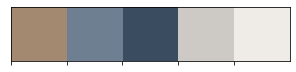

In [16]:
colors = ['#A38970','#6E7F91', '#394C60', '#CDCAC5', '#EFECE7']
sns.palplot(sns.color_palette(colors))

Let's check the target values distribution.

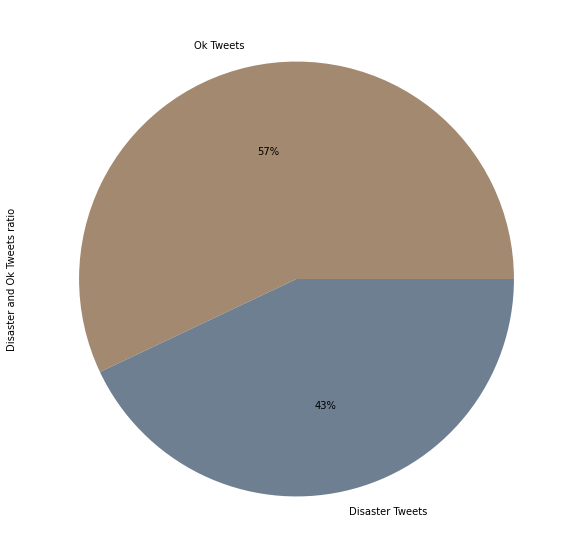

In [17]:
dTrain.target.value_counts().plot(kind = 'pie', figsize=(20,10), 
                                  colors = colors, 
                                  labels = ['Ok Tweets', 'Disaster Tweets'], 
                                  ylabel = 'Disaster and Ok Tweets ratio',
                                  autopct='%1.0f%%')
plt.show()

<AxesSubplot:xlabel='target', ylabel='count'>

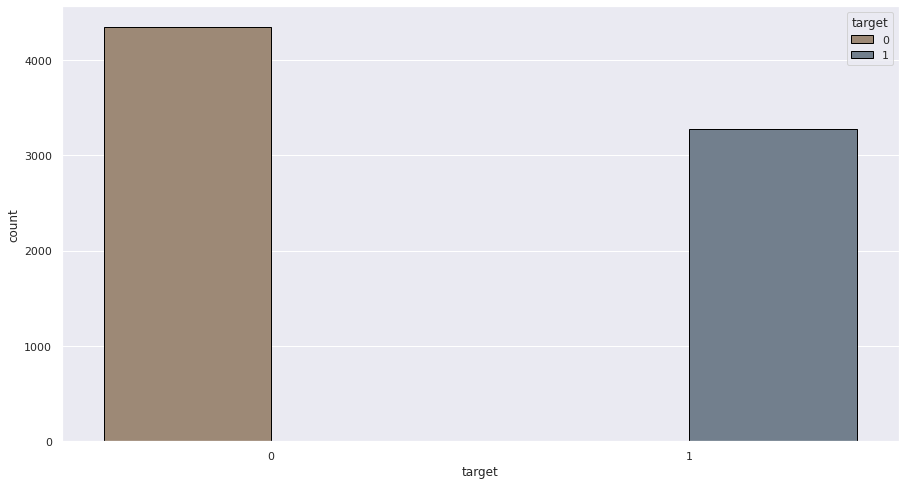

In [18]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x='target', data=dTrain, palette=colors, hue = 'target', edgecolor = 'black')

Double-check is never redundant.

In [19]:
Ok_tweets = dTrain['target'].value_counts().loc[0]
Dis_tweets = dTrain['target'].value_counts().loc[1]
print('The number of non-disaster/ok tweets: '+str(Ok_tweets))
print('The number of disaster tweets: '+str(Dis_tweets))

The number of non-disaster/ok tweets: 4342
The number of disaster tweets: 3271


From the data head and tail, we may notice that there is a column containing keywords. 
And, consequently, it is reasonable to analyze if there is correlation between specific keywords and target value which represents disaster tweets.

In [20]:
dTrain[dTrain['keyword'].notnull()].target.value_counts()

0    4323
1    3229
Name: target, dtype: int64

In [21]:
dTrain[dTrain['target'] == 1].keyword.value_counts()

derailment     39
wreckage       39
outbreak       39
debris         37
oil%20spill    37
               ..
blazing         1
epicentre       1
body%20bag      1
electrocute     1
ruin            1
Name: keyword, Length: 220, dtype: int64

In [22]:
dTrain[dTrain['target'] == 0].keyword.value_counts()

body%20bags          40
harm                 37
armageddon           37
wrecked              36
ruin                 36
                     ..
typhoon               1
suicide%20bombing     1
suicide%20bomber      1
outbreak              1
oil%20spill           1
Name: keyword, Length: 218, dtype: int64

In [23]:
dTrain[dTrain['target'] == 1].keyword.value_counts().head(10)

derailment           39
wreckage             39
outbreak             39
debris               37
oil%20spill          37
typhoon              37
evacuated            32
suicide%20bombing    32
rescuers             32
suicide%20bomb       32
Name: keyword, dtype: int64

In [24]:
dTrain[dTrain['target'] == 0].keyword.value_counts().head(10)

body%20bags    40
harm           37
armageddon     37
wrecked        36
ruin           36
deluge         36
explode        35
twister        35
fear           35
siren          35
Name: keyword, dtype: int64

Indeed, some keywords determine disaster tweets, to more extent, than the others. 

For example, 'typhoon' will likely lead us to disaster tweets and 'ruin' to target = 0. Now, we'll visualize it.

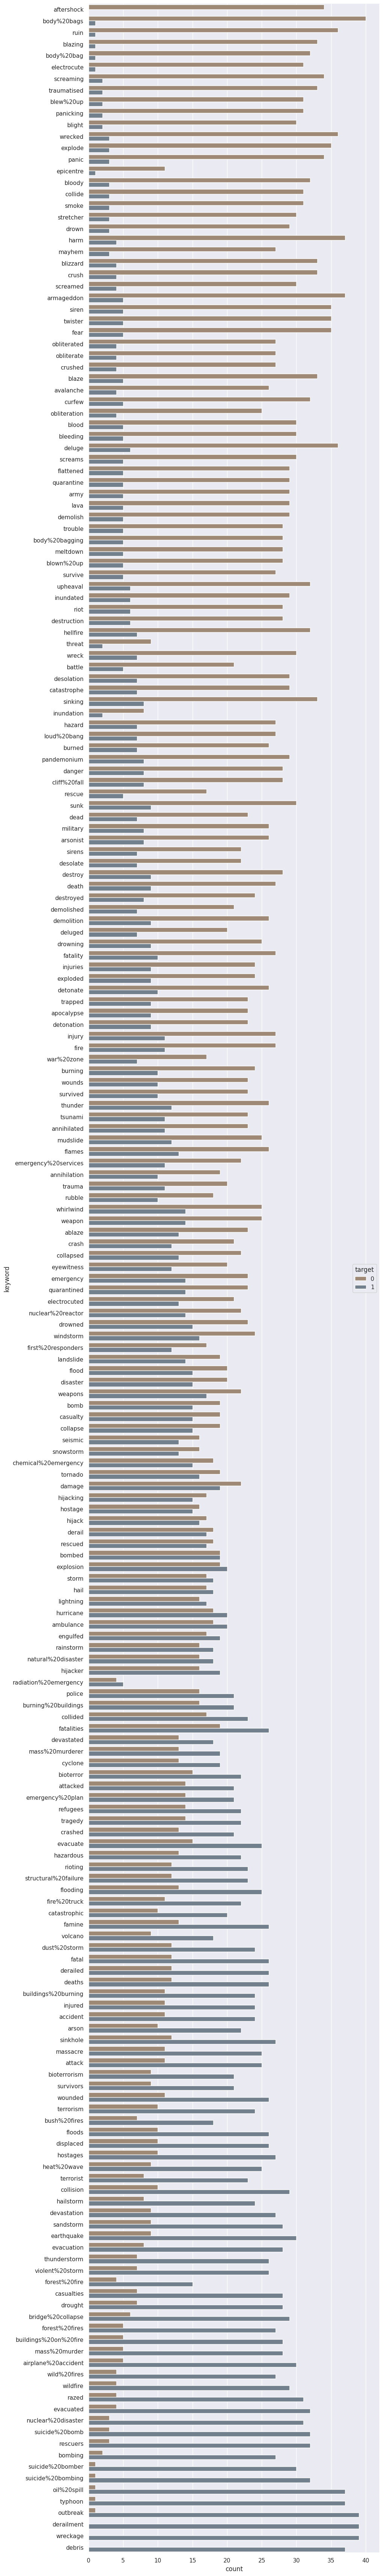

In [25]:
dTrain['target_mean'] = dTrain.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(10, 90), dpi = 100)
sns.countplot(y = dTrain.sort_values(by = 'target_mean')['keyword'],
             hue = dTrain.sort_values(by = 'target_mean')['target'], palette = colors)
plt.show()

In [26]:
dTrain.drop(columns=['target_mean'], inplace=True)

As we mainly work with text, namely tweets, we should pay attention to the fact that the Internet language differs from our day-to-day communication. 

That's why, it is logically approved to try to find any relevance between our target values and metrics used in SMM. 
Number of symbols (because Twitter counts not words, but symbols, marks and spaces), mentions and hashtags are what we will focus on next.

In [27]:
dTrain_update = dTrain.copy()
dTrain_update['symbols_count'] = dTrain_update['text'].apply(lambda x: len(list(x)))
dTrain_update['mention_count'] = dTrain_update['text'].apply(lambda x: len([z for z in str(x) if z == '@']))
dTrain_update['hashtag_count'] = dTrain_update['text'].apply(lambda x: len([z for z in str(x) if z == '#']))
dTrain_update.head(10)

,id,keyword,location,text,target,symbols_count,mention_count,hashtag_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,0,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,0,2
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,110,0,3
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,95,0,2
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,59,0,0
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,79,0,0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,52,0,0


In [28]:
dTrain_update.drop('id', inplace=True, axis=1)
dTrain_update

,keyword,location,text,target,symbols_count,mention_count,hashtag_count
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,0,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,0,0
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,0,0
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,0,1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,0,2
...,...,...,...,...,...,...,...
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,0,0
7609,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,2,0
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,0,0
7611,NaN,NaN,Police investigating after an e-bike collided ...,1,137,0,0


In [29]:
dTrain_update_disaster = dTrain_update['target'] == 1
dTrain_update_ok = dTrain_update['target'] == 0

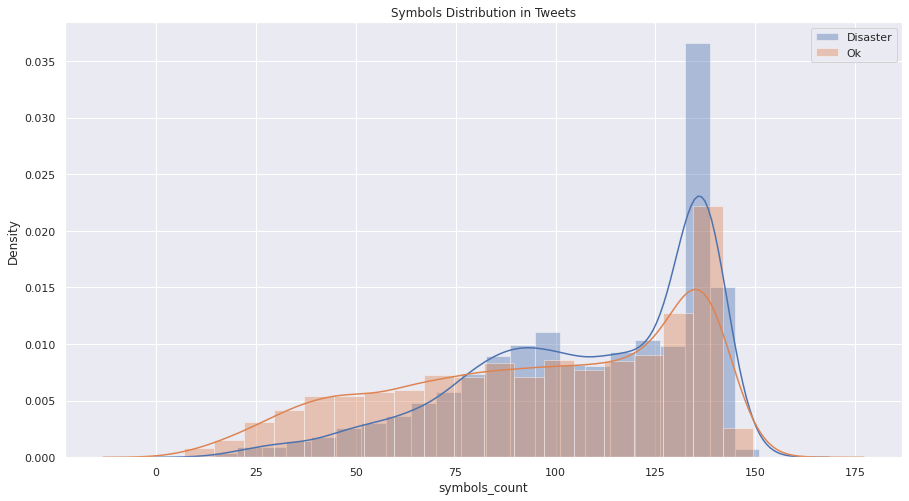

In [30]:
sns.distplot(dTrain_update[dTrain_update_disaster]['symbols_count'], label = 'Disaster', kde = True).set_title("Symbols Distribution in Tweets")
sns.distplot(dTrain_update[dTrain_update_ok]['symbols_count'], label = 'Ok', kde = True)
plt.legend()
plt.show()

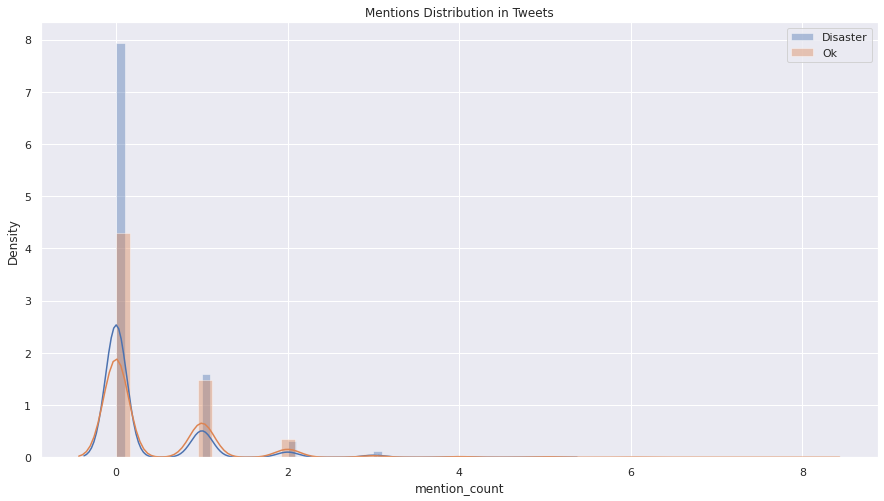

In [31]:
sns.distplot(dTrain_update[dTrain_update_disaster]['mention_count'], label = 'Disaster', kde = True).set_title("Mentions Distribution in Tweets")
sns.distplot(dTrain_update[dTrain_update_ok]['mention_count'], label = 'Ok', kde = True)
plt.legend()
plt.show()

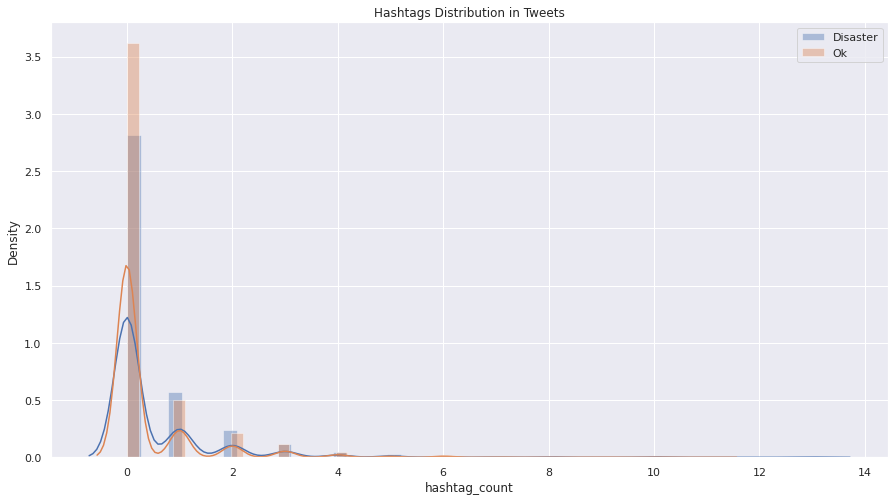

In [32]:
sns.distplot(dTrain_update[dTrain_update_disaster]['hashtag_count'], label = 'Disaster', kde = True).set_title("Hashtags Distribution in Tweets")
sns.distplot(dTrain_update[dTrain_update_ok]['hashtag_count'], label = 'Ok', kde = True)
plt.legend()
plt.show()

Eventually, there is not much we can explore from metrics above. Thereby, from this moment we work only with texts themselves. 

We'll commence with the text preprocessing, deleting all hastags, web adresses, emoji, mentions and all that mess that we wouldn't like to tokenize.

In [33]:
def purify(text):
    whitespace = re.compile(r"\s+")
    web_address1 = re.compile(r"(?i)https:\/\/[a-z0-9.~_\-\/]+")
    web_address2 = re.compile(r"(?i)http:\/\/[a-z0-9.~_\-\/]+")
    mention = re.compile(r"(?i)@[a-z0-9_]+")
    html = re.compile(r'<.*?>')
    emoji = re.compile("["
                          u"\U0001F600-\U0001F64F"  
                          u"\U0001F300-\U0001F5FF"  
                          u"\U0001F680-\U0001F6FF"  
                          u"\U0001F1E0-\U0001F1FF"  
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)
    text = whitespace.sub(' ', text)
    text = web_address1.sub('', text)
    text = web_address2.sub('', text)
    text = mention.sub('', text)
    text = html.sub('', text)
    text = emoji.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text.lower()

In [34]:
dTrain.text = [purify(i) for i in dTrain.text]

In this case, the process of tokenization is regular.

In [35]:
max_words = 10000
tokenizer = Tokenizer(num_words = max_words, filters = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower = True, split = ' ', oov_token = 'unknown', char_level = False)
tokenizer.fit_on_texts(dTrain.text)
items = list(tokenizer.word_index.items())

Then we check the results of tokenization.

In [36]:
print("Size of the dictionary", len(items))

Size of the dictionary 15003


In [37]:
# print("The index of the word is: ", tokenizer.word_index[input("Write a specific word: ")]) - you can try it yourself

In [38]:
trainWI = tokenizer.texts_to_sequences(dTrain.text)
print("Have a look at the fragment of training text:")
print("Originally:                                  ", dTrain.text[1])
print("As the index sequence:                       ", trainWI[1])

Have a look at the fragment of training text:
Originally:                                   forest fire near la ronge sask canada
As the index sequence:                        [177, 42, 213, 674, 6358, 6359, 1325]


In [39]:
xTrain = pad_sequences(trainWI, padding = 'pre')
yTrain = dTrain.target.to_numpy()
yTrain.shape, xTrain.shape

((7613,), (7613, 31))

We have turnt our texts into tokens and now we get them split into 4 subsets.

In [40]:
xtrain, xtest, ytrain, ytest = train_test_split(xTrain, yTrain, test_size = 0.3)
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(5329, 31)
(5329,)
(2284, 31)
(2284,)


Let's try a pretty simple model.

In [41]:
modelE = Sequential()
modelE.add(Embedding(input_dim = max_words, output_dim = 64, input_length=31))
modelE.add(GlobalAveragePooling1D())
modelE.add(Dense(64, activation='relu'))
modelE.add(Dense(32, activation='relu'))
modelE.add(Dense(1, activation='sigmoid'))

modelE.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

modelE.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 64)            640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 646,273
Trainable params: 646,273
Non-trainable params: 0
_________________________________________________________________


2022-07-26 12:34:37.923685: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


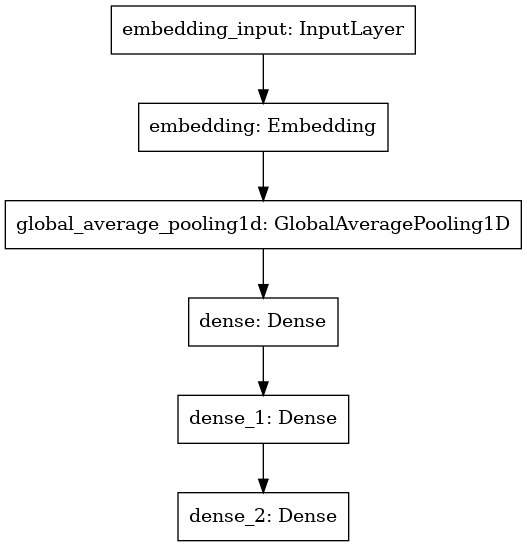

In [42]:
utils.plot_model(modelE)

In [43]:
history_e = modelE.fit(xTrain, yTrain, epochs=10, verbose = 1, validation_data = (xtest, ytest))

2022-07-26 12:34:39.387724: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
238/238 [==============================] - 4s 11ms/step - loss: 0.5800 - accuracy: 0.6882 - val_loss: 0.3771 - val_accuracy: 0.8468
Epoch 2/10
238/238 [==============================] - 2s 8ms/step - loss: 0.3581 - accuracy: 0.8496 - val_loss: 0.2591 - val_accuracy: 0.9085
Epoch 3/10
238/238 [==============================] - 2s 8ms/step - loss: 0.2621 - accuracy: 0.8996 - val_loss: 0.1906 - val_accuracy: 0.9356
Epoch 4/10
238/238 [==============================] - 2s 9ms/step - loss: 0.2008 - accuracy: 0.9250 - val_loss: 0.1685 - val_accuracy: 0.9352
Epoch 5/10
238/238 [==============================] - 2s 8ms/step - loss: 0.1610 - accuracy: 0.9418 - val_loss: 0.1214 - val_accuracy: 0.9558
Epoch 6/10
238/238 [==============================] - 2s 8ms/step - loss: 0.1370 - accuracy: 0.9497 - val_loss: 0.0987 - val_accuracy: 0.9637
Epoch 7/10
238/238 [==============================] - 2s 8ms/step - loss: 0.1194 - accuracy: 0.9544 - val_loss: 0.0929 - val_accuracy: 0.9645
Epoch

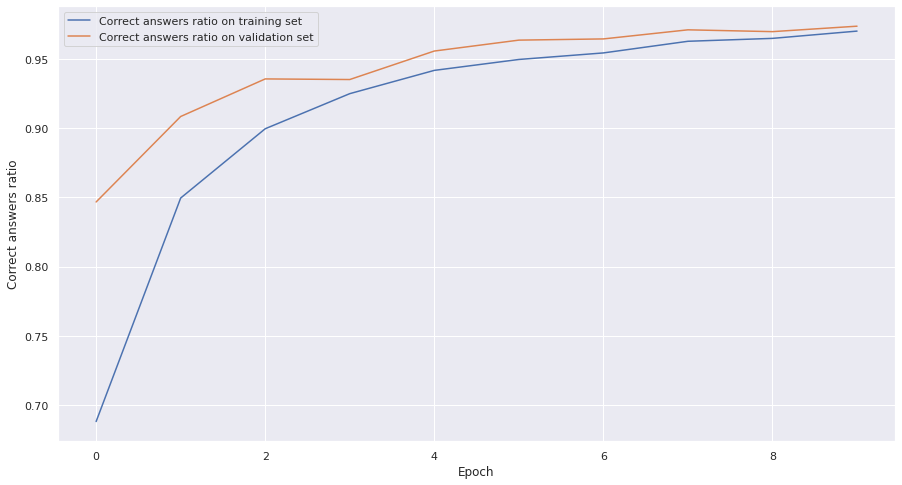

In [44]:
plt.plot(history_e.history['accuracy'], 
         label='Correct answers ratio on training set')
plt.plot(history_e.history['val_accuracy'], 
         label='Correct answers ratio on validation set')
plt.xlabel('Epoch')
plt.ylabel('Correct answers ratio')
plt.legend()
plt.show()

According to plot we succeded to build a good model.

So, let's use test data, that also was given with task.


In [45]:
dTest = dTest.drop(columns=['keyword', 'location', 'id'])
dTest.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [46]:
dTest_update = dTest.copy()
dTest_update.text = [purify(i) for i in dTest.text]
max_words = 10000
tokenizer = Tokenizer(num_words = max_words, filters = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower = True, split = ' ', oov_token = 'unknown', char_level = False)
tokenizer.fit_on_texts(dTest.text)
items = list(tokenizer.word_index.items())

In [47]:
testWI = tokenizer.texts_to_sequences(dTest.text)
Test_pad = pad_sequences(testWI, padding = 'pre')
Test_pad.shape

(3263, 31)

In [48]:
Test_prediction = modelE.predict(Test_pad)

In [49]:
def predition_accuracy(model, xTest, ModelName):
  print(f'Result of the  {ModelName}: ')
  for i in (Test_prediction):
    index = int((input('Choose a number of the tweet from 1 to 3263: ')))
    print(f'Model considers this tweet to be about a disaster with the probability of :{float((Test_prediction[index-1]))*100 :.2f} %')
    if Test_prediction[index-1] > 0.8:
      print('Model thinks that this is likely a disaster tweet')
    else:
      print('Model thinks that this is likely not a disaster tweet')
    print(f'Text of the tweet:\n{dTest.text[index-1]}')
    break

In [50]:
#print(predition_accuracy(modelE,Test_prediction, 'Sequential model With Embedding')) - you can check it yourself

We may try a slightly more complicated Bidirectional GRU model just for fun.

In [51]:
modelGRU = Sequential()
modelGRU.add(Embedding(max_words, 64, input_length = 31))
modelGRU.add(SpatialDropout1D(0.4))
modelGRU.add(BatchNormalization())
modelGRU.add(Bidirectional(LSTM(8, return_sequences = True)))
modelGRU.add(Bidirectional(LSTM(8, return_sequences = True)))
modelGRU.add(Dropout(0.3))
modelGRU.add(BatchNormalization())
modelGRU.add(GRU(32, return_sequences = True, reset_after = True))
modelGRU.add(GRU(32, reset_after = True))
modelGRU.add(Dropout(0.3))
modelGRU.add(BatchNormalization())
modelGRU.add(Dense(32, activation = 'relu'))
modelGRU.add(Dropout(0.3))
modelGRU.add(BatchNormalization())
modelGRU.add(Dense(1, activation = 'sigmoid'))

modelGRU.compile(optimizer = Adam(lr=1e-3),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

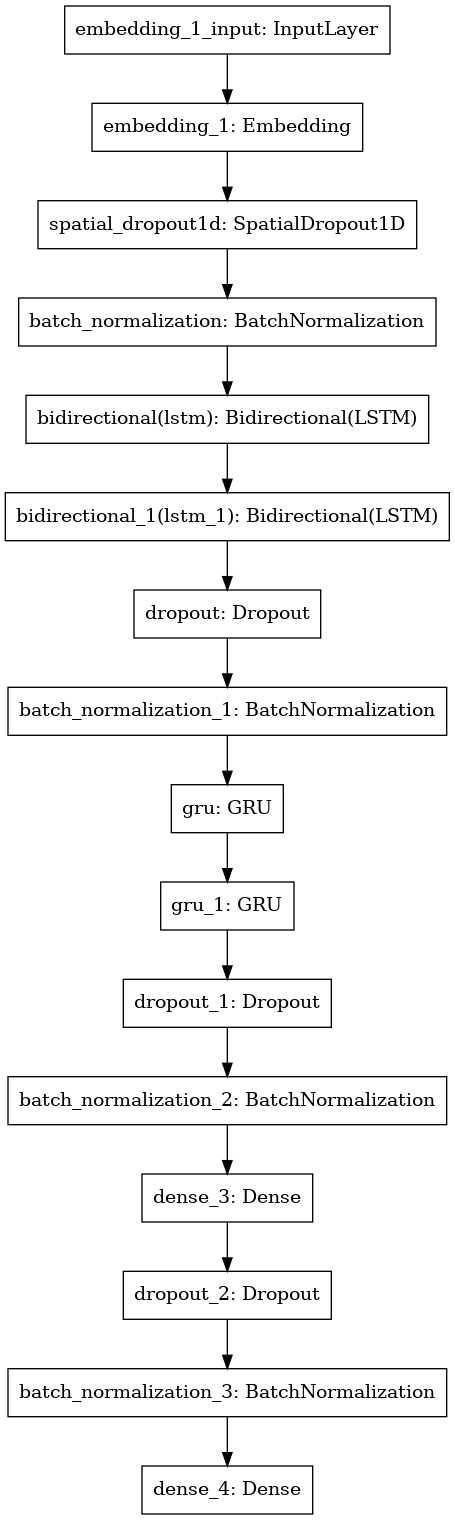

In [52]:
utils.plot_model(modelGRU)

In [53]:
history_GRU = modelGRU.fit(xtrain,
                      ytrain,
                      epochs = 15,
                      batch_size = 30,
                      validation_data = (xtest, ytest))

Epoch 1/15
178/178 [==============================] - 39s 136ms/step - loss: 0.7398 - accuracy: 0.5620 - val_loss: 0.6789 - val_accuracy: 0.5696
Epoch 2/15
178/178 [==============================] - 21s 119ms/step - loss: 0.5534 - accuracy: 0.7281 - val_loss: 0.5364 - val_accuracy: 0.7404
Epoch 3/15
178/178 [==============================] - 21s 116ms/step - loss: 0.3926 - accuracy: 0.8369 - val_loss: 0.5148 - val_accuracy: 0.7785
Epoch 4/15
178/178 [==============================] - 21s 118ms/step - loss: 0.3049 - accuracy: 0.8793 - val_loss: 0.6136 - val_accuracy: 0.7758
Epoch 5/15
178/178 [==============================] - 22s 122ms/step - loss: 0.2286 - accuracy: 0.9199 - val_loss: 0.6880 - val_accuracy: 0.7680
Epoch 6/15
178/178 [==============================] - 22s 123ms/step - loss: 0.1954 - accuracy: 0.9300 - val_loss: 0.7059 - val_accuracy: 0.7609
Epoch 7/15
178/178 [==============================] - 22s 123ms/step - loss: 0.1754 - accuracy: 0.9377 - val_loss: 0.8404 - val_ac

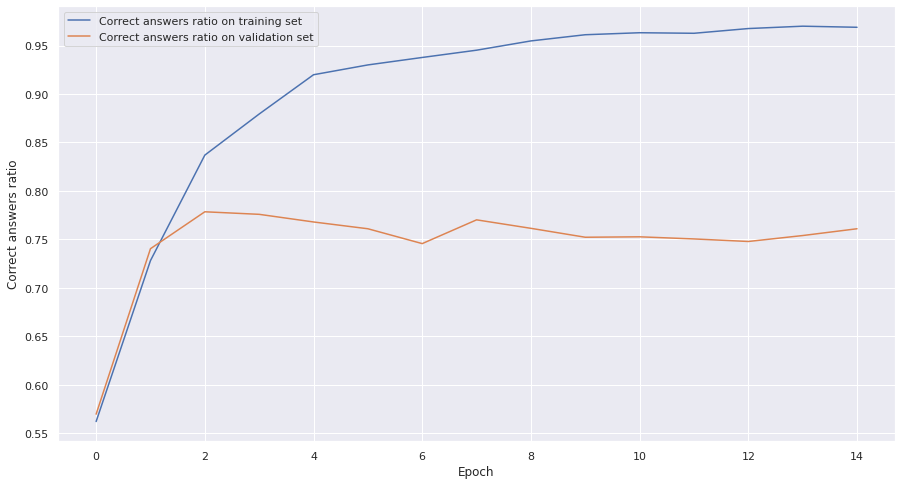

In [54]:
plt.plot(history_GRU.history['accuracy'], label = 'Correct answers ratio on training set')
plt.plot(history_GRU.history['val_accuracy'], label = 'Correct answers ratio on validation set')
plt.xlabel('Epoch')
plt.ylabel('Correct answers ratio')
plt.legend()
plt.show()

Without further ado, we see overfitting. So, the complex model never means to be effective as well.

In [55]:
#print(predition_accuracy(modelGRU,Test_prediction, 'Sequential GRU model')) - you can check it yourself

LSTM models show good perfomance with text processing.

In [60]:
model_LSTMBid = Sequential()
model_LSTMBid.add(Embedding(max_words, 64, input_length = 31))
model_LSTMBid.add(Dropout(0.4))
model_LSTMBid.add(Bidirectional(LSTM(64)))
model_LSTMBid.add(BatchNormalization())
model_LSTMBid.add(Dense(32, activation = 'relu'))
model_LSTMBid.add(Dropout(0.3))
model_LSTMBid.add(BatchNormalization())
model_LSTMBid.add(Dense(1, activation='sigmoid'))

model_LSTMBid.compile(optimizer= RMSprop(lr=0.0001),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [61]:
model_LSTMBid.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 31, 64)            640000    
_________________________________________________________________
dropout_7 (Dropout)          (None, 31, 64)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 32)               

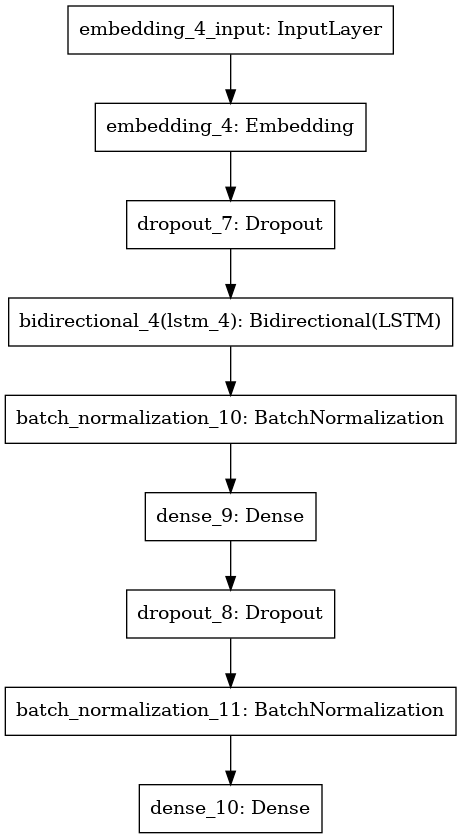

In [62]:
utils.plot_model(model_LSTMBid)

In [63]:
history_LSTMBid = model_LSTMBid.fit(xtrain, ytrain, epochs=15, validation_data=(xtest, ytest))

Epoch 1/15
167/167 [==============================] - 18s 71ms/step - loss: 0.8286 - accuracy: 0.5185 - val_loss: 0.7001 - val_accuracy: 0.4304
Epoch 2/15
167/167 [==============================] - 10s 61ms/step - loss: 0.7631 - accuracy: 0.5643 - val_loss: 0.7011 - val_accuracy: 0.4523
Epoch 3/15
167/167 [==============================] - 10s 61ms/step - loss: 0.7094 - accuracy: 0.5945 - val_loss: 0.6625 - val_accuracy: 0.5779
Epoch 4/15
167/167 [==============================] - 10s 60ms/step - loss: 0.6617 - accuracy: 0.6412 - val_loss: 0.5841 - val_accuracy: 0.6926
Epoch 5/15
167/167 [==============================] - 11s 64ms/step - loss: 0.6034 - accuracy: 0.6889 - val_loss: 0.5488 - val_accuracy: 0.7360
Epoch 6/15
167/167 [==============================] - 10s 61ms/step - loss: 0.5632 - accuracy: 0.7163 - val_loss: 0.5320 - val_accuracy: 0.7513
Epoch 7/15
167/167 [==============================] - 10s 60ms/step - loss: 0.5197 - accuracy: 0.7500 - val_loss: 0.5761 - val_accuracy:

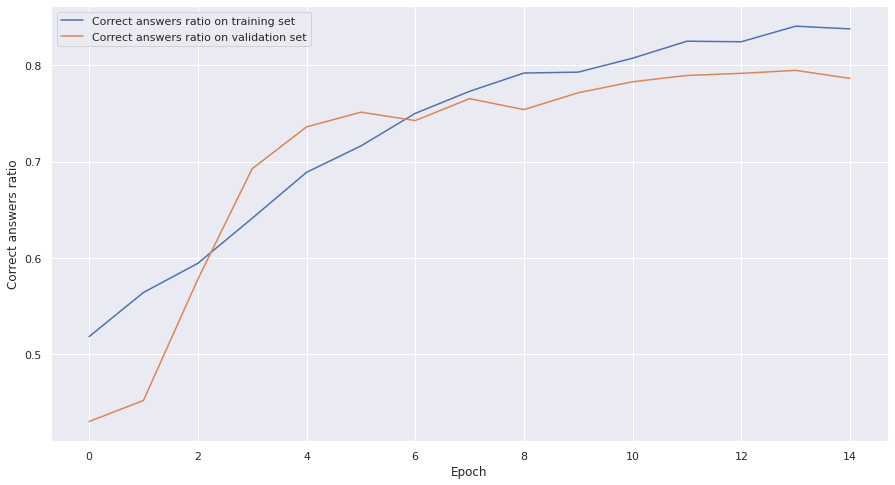

In [64]:
plt.plot(history_LSTMBid.history['accuracy'], label = 'Correct answers ratio on training set')
plt.plot(history_LSTMBid.history['val_accuracy'], label = 'Correct answers ratio on validation set')
plt.xlabel('Epoch')
plt.ylabel('Correct answers ratio')
plt.legend()
plt.show()

In [ ]:
#print(predition_accuracy(mode_LSTMBid,Test_prediction, 'Sequential Bidirectional LSTM model')) - you can check it yourself

Thank you for your attention!